In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Dataset paths
fake_path = "/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/merged_vectors.csv"
real_path = "/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/merged_vectors_real.csv"

# Load
df_fake = pd.read_csv(fake_path)
df_real = pd.read_csv(real_path)

df_fake['label'] = 1
df_real['label'] = 0

df_all = pd.concat([df_fake, df_real], ignore_index=True)
print("Dataset shape:", df_all.shape)


2025-09-28 21:56:36.257414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 21:56:36.287227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 21:56:37.006187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Dataset shape: (32370, 3910)


In [2]:
numeric_cols = df_all.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('label')

X = df_all[numeric_cols].values
y = df_all['label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (32370, 3908)


In [3]:
sequence_len = 30
n_features = X_scaled.shape[1]

def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    n_samples = X.shape[0] // seq_len
    for i in range(n_samples):
        seq = X[i*seq_len:(i+1)*seq_len]
        sequences.append(seq)
        labels.append(y[i*seq_len])
    return np.array(sequences), np.array(labels)

X_seq, y_seq = create_sequences(X_scaled, y, sequence_len)
print("Sequences shape:", X_seq.shape, y_seq.shape)


Sequences shape: (1079, 30, 3908) (1079,)


In [4]:
def build_bilstm(seq_len, n_features):
    inp = Input(shape=(seq_len, n_features))
    
    x = Bidirectional(LSTM(128, return_sequences=False))(inp)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=out)
    return model


In [5]:
n_splits = 5
batch_size = 8
epochs = 20
results = []
all_histories = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_seq, y_seq), 1):
    print(f"\n===== Fold {fold} =====")
    
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

    model = build_bilstm(sequence_len, n_features)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.keras"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    # Evaluate best model
    model.load_weights(model_path)
    y_pred_prob = model.predict(X_val).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'auc': roc_auc_score(y_val, y_pred_prob)
    })

# Summary
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


2025-09-28 21:56:45.265191: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4875 - loss: 0.6931
Epoch 1: val_accuracy improved from None to 0.50000, saving model to best_model_fold1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.4890 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5206 - loss: 0.6932
Epoch 2: val_accuracy did not improve from 0.50000
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5072 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.50000
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4924 - loss: 0.6932
Epoch 4: val_accuracy 

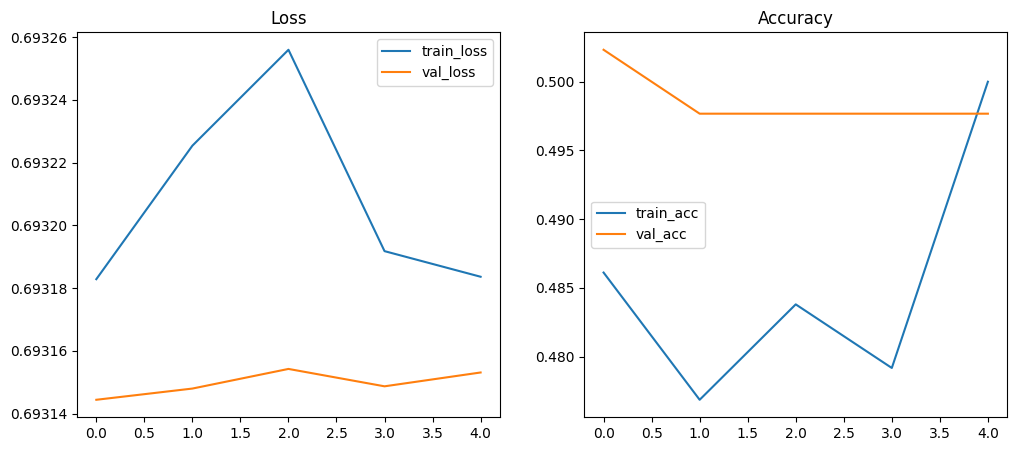

In [6]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(all_histories[-1]['loss'], label='train_loss')
plt.plot(all_histories[-1]['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(all_histories[-1]['accuracy'], label='train_acc')
plt.plot(all_histories[-1]['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.show()
